# Notebook example of genetic algorithms for optimization problems 
In this notebook we are using the deap framework for the usecase of the Schaffer function as a general optimization problem.

## 1. The Schaffer N. 1 multi-objective function

#### Same as in our simple example
---
The Schaffer N. 1 multi-objective function is a testfunction for optimization problems, which consists of two simple functions. It takes into account only x and as the two functions span a curve, it can be used to create a nice plot for visualization of the optimization steps. The two functions building the Schaffer function are:
- f1(x) = x <sup>2</sup>
- f2(x) = (x - 2) <sup>2</sup>

---

#### New

This time we want to modify the Schaffer function in order to make it a more complex problem. Therefor we will introduce a helper function that will generate an x value based on another array. This way we can optimize the Schaffer function by constantly updating the array to try and find our x in [0, 2] and thus minimize both the lower functions as given above.

Now let's define the helper function:

g(a<sup>n</sup>) = a<sub>0</sub> + a<sub>1</sub> * 2<sup>1</sup> * a<sub>2</sub> * 2<sup>2</sup> + ... + a<sub>n</sub> * 2<sup>n</sup>

In [70]:
# Our helper function
def g(array):
    x = 1
    for exponent, a in enumerate(array):
        x += a * 2 ** exponent
        
    return x

# Extremes
# for 8 numbers
print(g([-4] * 8), g([4] * 8))
# for 15 numbers
print(g([-4] * 12), g([4] * 12))

-1019 1021
-16379 16381


This function can handle our objectives for 
* an array of length 9 
* the array values being in range [-4, 4]

It's extremes are 
* -1019 for all values being -4 
* +1021 for all values being +4.

## 2. Creating all basic functions for Schaffer and individuals

Here we will write all our functions to calculate and evaluate the Schaffer function as well as create individuals for our population. Here our make_individual will also take a second argument that defines the number of properties of an individual as given by A_NUMS in this case.

In [79]:
# Import of numpy which is used for picking random numbers as well as scaling those numbers up to our given limits
import numpy as np

# Range of values used for x1, x2
X_RANGE = (-100000, 100000)

x_vals = np.arange(X_RANGE[0], X_RANGE[1] + 1, 0.1)

# Minimum and maximum of our values; this time -4, +4 as our function then will generate our "real" boundaries 
# as given before with X_RANGE = (-1000, 1000)
A_RANGE = (-4, 4)

# Define the number of values needed for our function
A_NUMS = 12

# Schaffer functions f1, f2
def schaffer_f1(x):
    return x ** 2

def schaffer_f2(x):
    return (x - 2) ** 2

# Schaffer evaluation function
def schaffer_eval(individual):
    # First get our x by calling the g function with unpacked individual
    x = g(individual)
    
    # Now return both function values
    return schaffer_f1(x), schaffer_f2(x)

# Function for creation of individual
# One random value [0, 1] is taken and projected on the range of limits as given in the parameter x_range
def make_individual(a_range, a_nums):
    return list(np.random.random(a_nums) * np.abs(np.diff(a_range)) + np.min(a_range))

# Vectorize Schaffer functions for plotting purpose
schaffer_f1_vec = np.vectorize(schaffer_f1)
schaffer_f2_vec = np.vectorize(schaffer_f2)

## 3. Creating the deap toolbox

We will again create our toolbox with deap, this time only with different individuals. 

The deap library (https://github.com/DEAP/deap, https://deap.readthedocs.io/en/master/) is a framework that offers everything one needs to simply setup a genetic algorithm concept. Therefor it provides the user with a set of initilization-, crossover-, mutation- as well as selection-functions that include proven methods. The way deap works makes it very easy to setup a run-ready system.


The following code initiates a deap framework with the following objectives:
- having a multi-objective optimization looking for minimization 
    * weights is a tuple with two values (weights = (-1, -1))
    * negative for minimization!
- creating a population of individuals which all have a random integers in a given range which stands for a reasonible limit for the function where function values behind those limits do not change relevant anymore
- giving an evaluation function which shall be optimized by the genetic algorithm (here: defined schaffer_eval)
    * the function is rewritten as ackley_eval where the only argument is the individual
    * inside there's one call of the ackley function with the above defined a, b, c parameters and the individual which is used for the given dimensions
- giving the function for mating which is chosen to be simulated binary bounded
    * this simulates a binary mating
    * in binary mating binary-coded values are used instead of real-coded ones
    * simulated binary crossover intends to replace this function by using distribution functions on which the real-coded values are crossed 
- giving the function for mutation which is chosen to be polynomial bounded
    * polynomial bounded mutation intends to create a mutation based on a polynomial probability function
    * values are limited by their bounds
- giving the function for selection which is here chosen as selNSGA2
    * selNSGA2 does a selection based on multiobjective optimization

It follows the article of Deb, 2002 [https://pdfs.semanticscholar.org/dc4e/c99d4201affa93f404c6b4e4f8538d07aeb5.pdf], who have developed the NSGA-2 algorithm and also have shown some composition of optimization solving by combining simulated binary bound crossover and polynomial bound mutation.
    
The mutation parameters given are:
- ETA
    * set to be 20
    * a parameter that defines how similiar children should be to their parents (could be called crowding distance)
    * Deb chose this value size without further explanation and it's still unclear what value exactely to choose
- LOW
    * set to be -1000
    * lower bound of our value
    * through mating and mutation values can't go lower then this value!
- UP
    * set to be 1000
    * upper bound of our value
    * through mating and mutation values can't go higher then this value!
- INDPB
    * set to be 0.05
    * independent probability value which is taken as gate to choose if mutation will happen or not
    * another check after MUTPB
- CXPB
    * set to be 0.5
    * crossing probability for which a random value has to be lower to make crossing happen
- MUTPB
    * set to be 0.2
    * mutation probability for which a random value has to be lower to make mutation happen

In [80]:
ETA = 20
LOW = A_RANGE[0]
UP = A_RANGE[1]
INDPB = 0.05
CXPB = 0.5 
MUTPB = 0.2

# Import of deap modules
from deap import base, creator, tools, algorithms

# Module base is used to create a container for the individuals that holds the fitness function as well as later added parameters (here: pair of x1, x2)
# First FitnessMin class is registered with weights according to optimization objective
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
# Second the Individual class having a list container with parameters and a fitness value is created
creator.create("Individual", list, fitness=creator.FitnessMin)

# Now toolbox with genetic algorithm functions is created
toolbox = base.Toolbox()
# Candidate (container for individual) is added with function make_individual that creates a pair of x1, x2 values; function is called with limits of x1, x2 respectively
toolbox.register("candidate", make_individual, A_RANGE, A_NUMS)
# Individuals are created by calling the candidate function which again calls the make_individual function
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.candidate)
# Population is created putting a number of individuals in a list
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Evaulate function is set as ackley_eval as defined before
toolbox.register("evaluate", schaffer_eval)

# Function for mating is set to be simulated binary bounded (means parameters can't leave the given range of bounds)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=ETA, low=LOW, up=UP)
# Function for mutatiion is set to be polynomial bounded and again parameters can#t leave their bounds
toolbox.register("mutate", tools.mutPolynomialBounded, eta=ETA, low=LOW, up=UP, indpb=INDPB)
# toolbox.register("select", tools.selNSGA2)
# Selection is set to be selBest which simply picks k best individuals of population to be the new generation population start
toolbox.register("select", tools.selNSGA2)

## 4. Running the genetic algorithm on a population of modified individuals
We have set up our toolbox and now want to see what the algorithm is capable of. Again we will use easimple as guidance. This means mating and mutation is independent of each other and can happen at the same time/generation.

In [119]:
# Import deepcopy
from copy import deepcopy

# Population size
POP_SIZE = 200
# Generations per step
GEN_PER_STEP = 1
# Number of steps
GEN_STEPS = 1000
# Popultion is build with size
pop = toolbox.population(n=POP_SIZE)
# Hall of fame is build as a pareto front (because of multi-objective optimization!)
hall_of_fame = tools.ParetoFront()

# Empty array for best individuals of every step is created
best_of_step = []

# For loop through steps
for step in range(GEN_STEPS):
    # Simple evolution applied; feedback returned to hall of fame; population is returned to overwrite success
    pop, _ = algorithms.eaSimple(pop, toolbox, CXPB, MUTPB, GEN_PER_STEP, halloffame=hall_of_fame, verbose=False)
    # Current hall of fame is copied and appended to best of
    best_of_step.append(list(deepcopy(hall_of_fame)))

C:\Users\benjamin\Anaconda3\envs\inowas\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


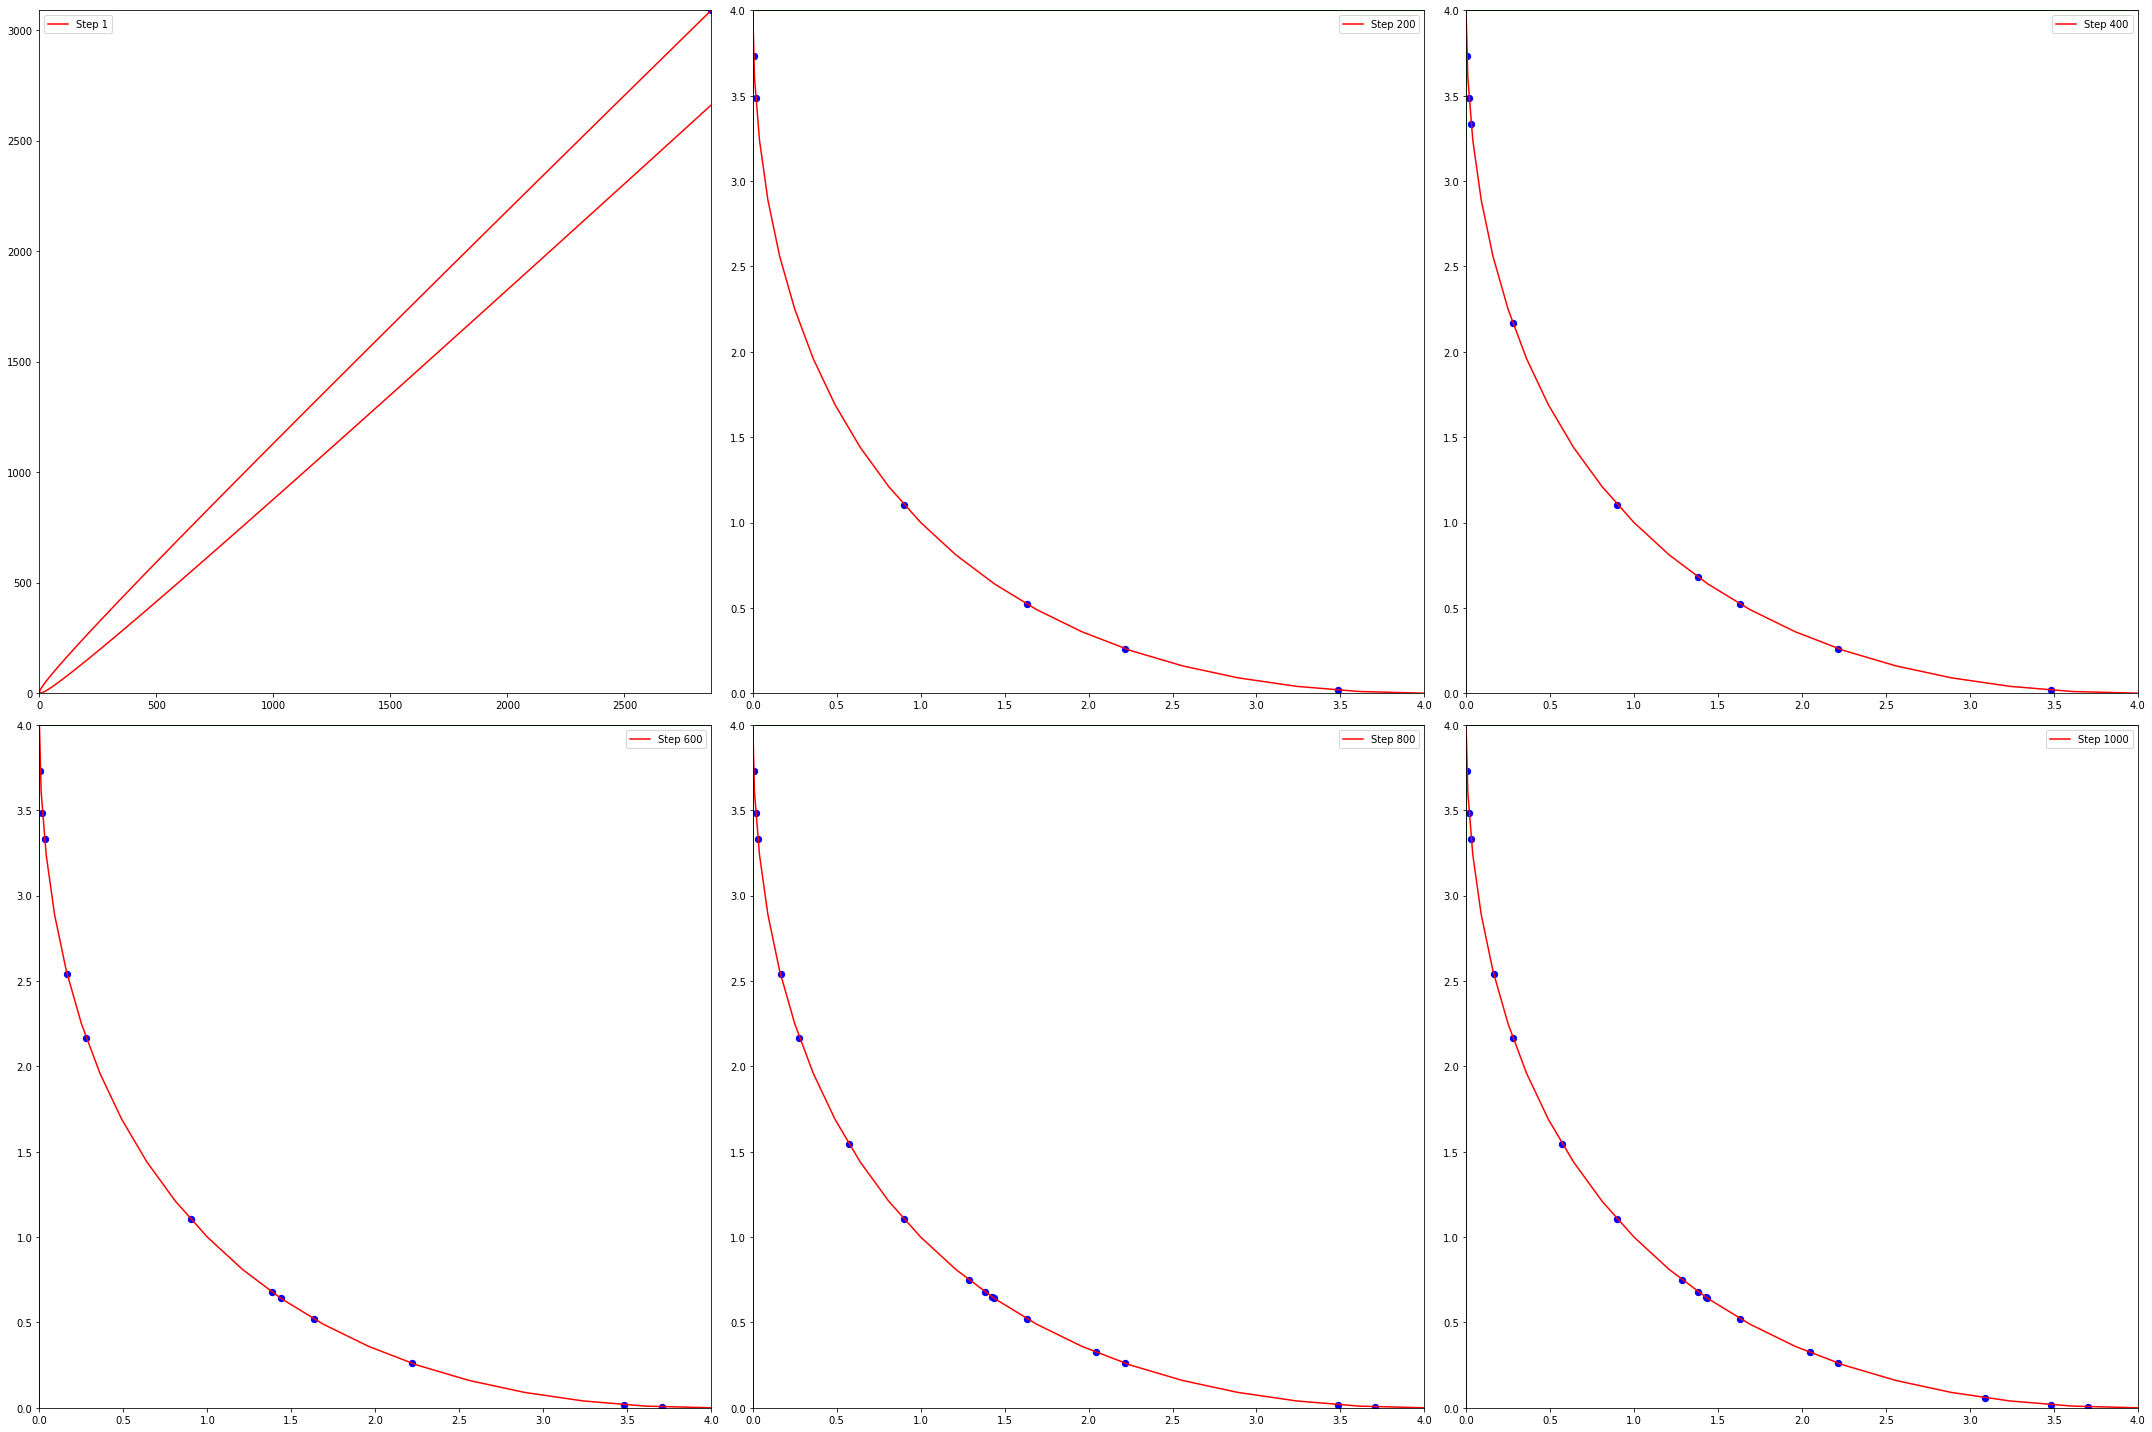

In [120]:
# Imports
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Rectangle

SCHAFFER_OPT = [0, 2]

# Create an empty figure, this time broader for space of three plots!
f = plt.figure(figsize=(30, 20))

# Add three subplots for the different states
ax1 = f.add_subplot(2, 3, 1)
ax2 = f.add_subplot(2, 3, 2)
ax3 = f.add_subplot(2, 3, 3)
ax4 = f.add_subplot(2, 3, 4)
ax5 = f.add_subplot(2, 3, 5)
ax6 = f.add_subplot(2, 3, 6)

# Give indizes of which solutions are picked
INDIZES = np.floor(np.linspace(0, len(best_of_step) - 1, 6)).astype(int)

# Loop through indizes combined with axes of subplots to create the graphs
for ax, ind in zip([ax1, ax2, ax3, ax4, ax5, ax6], INDIZES):
    # Calculating function values
    f1_values = schaffer_f1_vec([g(a_vec) for a_vec in best_of_step[ind]])
    f2_values = schaffer_f2_vec([g(a_vec) for a_vec in best_of_step[ind]])
    
    # Create a general plot of the function
    ax.plot(schaffer_f1_vec(x_vals), schaffer_f2_vec(x_vals), c="red", label="Step {}".format(str(ind + 1)))
    
    # Create scatters of the hall of fame solutions
    ax.scatter(f1_values, f2_values, c="blue", s=40)
    
    # Set plot limits
    ax.set_xlim((0, max(max(schaffer_f1_vec(SCHAFFER_OPT)), np.max(f1_values))))
    ax.set_ylim((0, max(max(schaffer_f2_vec(SCHAFFER_OPT)), np.max(f2_values))))
    
    # Create rectangle
    rect = Rectangle((0, 0), max(schaffer_f1_vec(SCHAFFER_OPT)), max(schaffer_f2_vec(SCHAFFER_OPT)), edgecolor="g", facecolor="none")
    # Adding to plot
    ax.add_patch(rect)
            
    ax.legend()
    
plt.tight_layout()
plt.show()
